# TODOs:
1. analyze outliars and decide to keep/transform/remove
2. <del> analyze nans (now are removed) and decide to transform/remove
3. add detailed EDA of interesting aspects
4. use names (cluster and classify using unsuervised methods) as features
5. try using PassengerId group number as int
6. add EDA and classification pipeline (preprocess + normalization + classification) to test data and create submission file
7. add kaggle submission and evaluation code

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Exploring train data

1. **PassengerId** - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
2. **HomePlanet** - The planet the passenger departed from, typically their planet of permanent residence.
3. **CryoSleep** - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
4. **Cabin** - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
5. **Destination** - The planet the passenger will be debarking to.
6. **Age** - The age of the passenger.
7. **VIP** - Whether the passenger has paid for special VIP service during the voyage.
8. **RoomService, FoodCourt, ShoppingMall, Spa, VRDeck** - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
9. **Name** - The first and last names of the passenger.

10. **Transported** - Whether the passenger was transported to another dimension. **This is the target to predict.**

In [2]:
train_df = pd.read_csv('./data/train.csv')
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [3]:
train_df.shape

(8693, 14)

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [5]:
train_df = train_df.dropna()
train_df.shape

(6606, 14)

## Feature engineering

In [6]:
# TODO: consider making detailed EDA for correlations between deck and socieconomic status (VIP, billing etc)
train_df[['CabinDeck', 'CabinNum', 'CabinSide']] = train_df['Cabin'].str.split(pat='/', n=2, expand=True)
train_df['CabinNum'] = train_df['CabinNum'].astype(float)
train_df = train_df.drop(['Cabin'], axis=1)

In [7]:
# TODO: consider doing this before dropna.
# TODO: consider using raw data of group and passenger numbers.
train_df[['PassengerId_g', 'PassengerId_p']] = train_df['PassengerId'].str.split(pat='_', n=1, expand=True)
train_df['PassengerId_p'] = train_df['PassengerId_p'].astype(float)
train_df['GroupSize'] = train_df.apply(lambda row: train_df[train_df['PassengerId_g'] == row.PassengerId_g].PassengerId_p.max(), axis=1)
train_df = train_df.drop(['PassengerId_g', 'PassengerId_p'], axis=1)
train_df = train_df.set_index('PassengerId', drop=True)

In [8]:
train_df = train_df.replace({'TRAPPIST-1e': 'Trappist', '55 Cancri e': 'Cancri', 'PSO J318.5-22': 'Pso'})

In [9]:
train_df[['NameFirst', 'NameLast']] = train_df['Name'].str.split(pat=' ', n=2, expand=True)
train_df = train_df.drop(['Name'], axis=1)

In [10]:
train_df = pd.get_dummies(train_df, columns=['HomePlanet', 'CabinDeck', 'CabinSide', 'VIP', 'CryoSleep', 'Destination'], drop_first=True)
train_df = train_df[[col for col in train_df.columns if col != 'Transported'] + ['Transported']]
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6606 entries, 0001_01 to 9280_02
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Age                   6606 non-null   float64
 1   RoomService           6606 non-null   float64
 2   FoodCourt             6606 non-null   float64
 3   ShoppingMall          6606 non-null   float64
 4   Spa                   6606 non-null   float64
 5   VRDeck                6606 non-null   float64
 6   CabinNum              6606 non-null   float64
 7   GroupSize             6606 non-null   float64
 8   NameFirst             6606 non-null   object 
 9   NameLast              6606 non-null   object 
 10  HomePlanet_Europa     6606 non-null   uint8  
 11  HomePlanet_Mars       6606 non-null   uint8  
 12  CabinDeck_B           6606 non-null   uint8  
 13  CabinDeck_C           6606 non-null   uint8  
 14  CabinDeck_D           6606 non-null   uint8  
 15  CabinDeck_E      

In [11]:
train_df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,CabinNum,GroupSize,HomePlanet_Europa,HomePlanet_Mars,...,CabinDeck_D,CabinDeck_E,CabinDeck_F,CabinDeck_G,CabinDeck_T,CabinSide_S,VIP_True,CryoSleep_True,Destination_Pso,Destination_Trappist
count,6606.000000,6606.000000,6606.000000,6606.000000,6606.000000,6606.000000,6606.000000,6606.000000,6606.000000,6606.000000,...,6606.000000,6606.000000,6606.000000,6606.000000,6606.000000,6606.000000,6606.000000,6606.000000,6606.000000,6606.000000
mean,28.894036,222.991674,478.958523,178.356494,313.161520,303.780048,599.177414,1.953981,0.253255,0.206933,...,0.056615,0.103391,0.325764,0.298668,0.000303,0.506358,0.024523,0.353012,0.094308,0.692704
std,14.533429,644.987936,1678.592291,576.328407,1144.016291,1127.142166,513.450585,1.532786,0.434908,0.405138,...,0.231123,0.304492,0.468695,0.457709,0.017399,0.499997,0.154678,0.477943,0.292279,0.461408
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,166.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,424.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
75%,38.000000,49.000000,82.750000,30.000000,65.000000,52.000000,994.000000,2.000000,1.000000,0.000000,...,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
max,79.000000,9920.000000,29813.000000,12253.000000,22408.000000,20336.000000,1894.000000,8.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


CPU times: total: 2min 25s
Wall time: 2min 25s


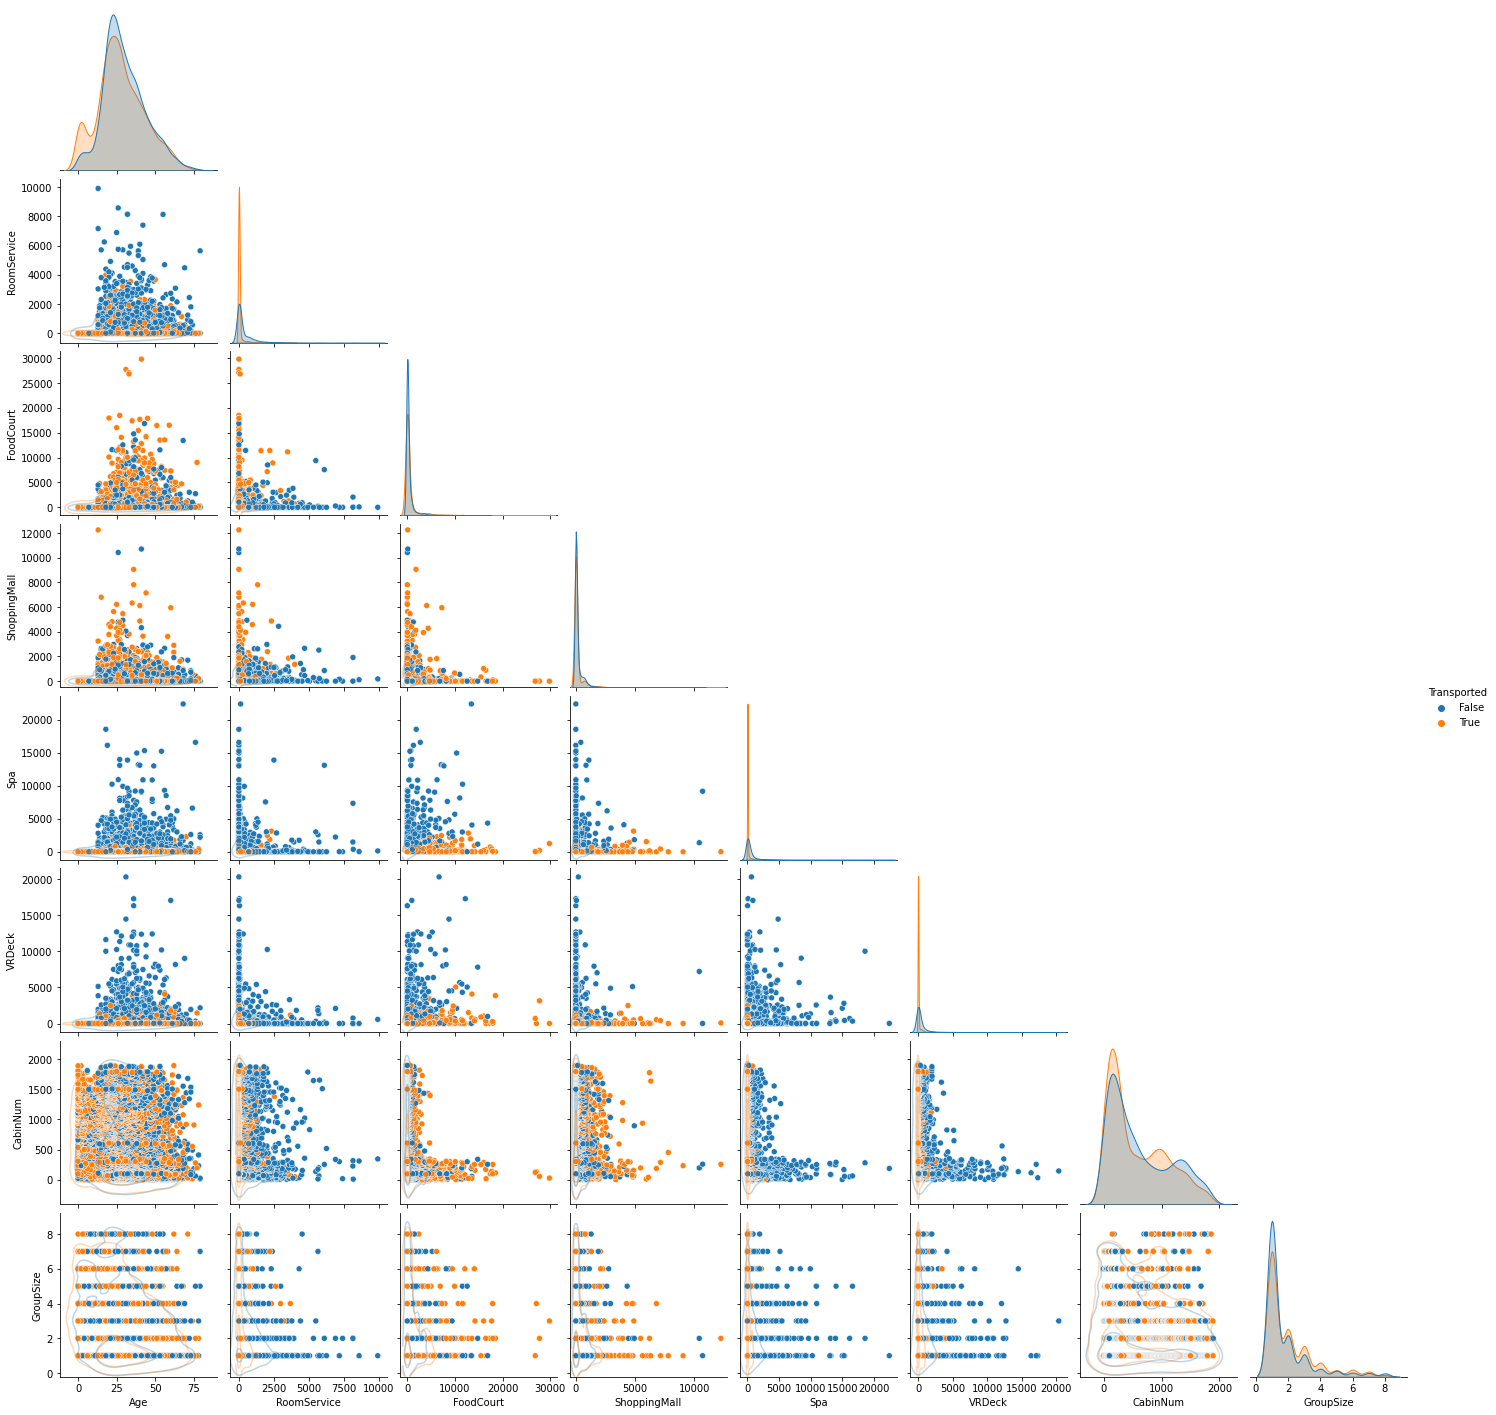

In [12]:
%%time
numerical_columns = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'CabinNum', 'GroupSize']
pairplot_graph = sns.pairplot(train_df[numerical_columns + ['Transported']], corner=True, hue='Transported', diag_kind="kde");
pairplot_graph.map_lower(sns.kdeplot, levels=3, color=".2", alpha=0.3);

CPU times: total: 297 ms
Wall time: 283 ms


<AxesSubplot:>

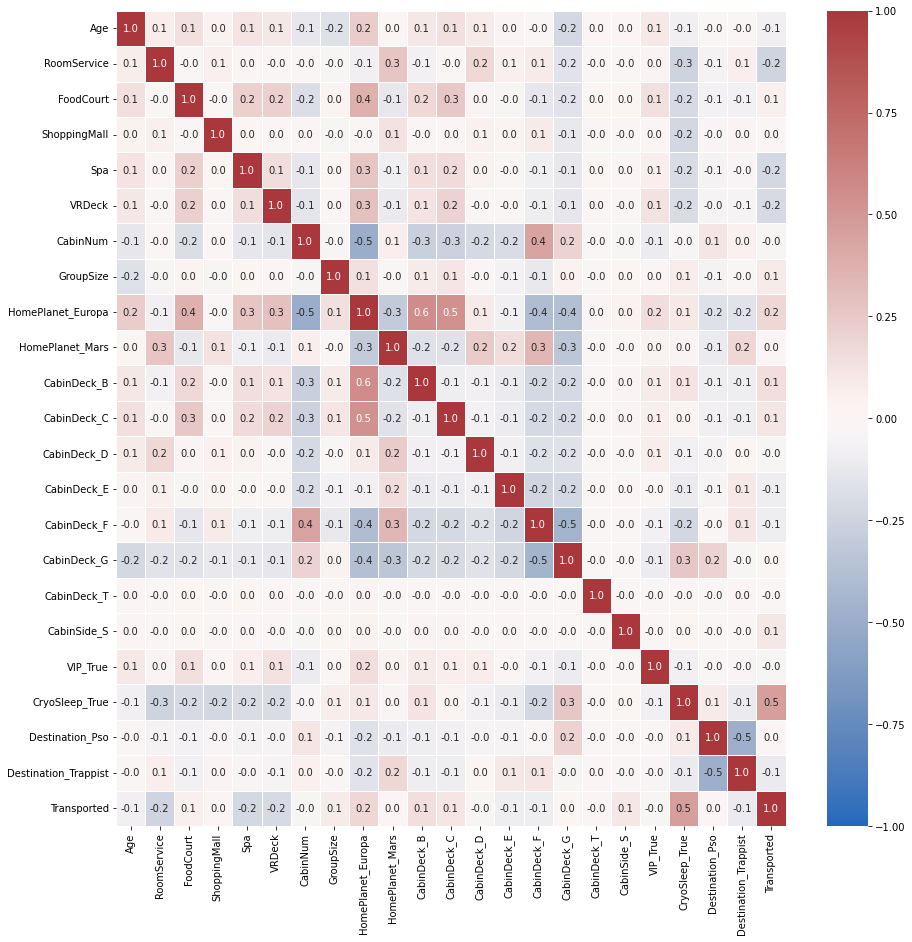

In [13]:
%%time
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(train_df.corr(), cmap='vlag', vmin=-1, vmax=1, annot=True, linewidths=.5, fmt='.1f', ax=ax);

## Explore outliers

In [14]:
# # TODO: should be revisited
# outliers_columns = [col for col in list(train_df.columns.values) if col not in ['NameFirst', 'NameLast', 'Transported']]
# outliers_df = pd.DataFrame(columns=train_df.columns)
# for col in outliers_columns:
#     col_outliers_df = train_df[(train_df[col]-train_df[col].mean())/train_df[col].std() > 3.1]
#     outliers_df = pd.concat([outliers_df, col_outliers_df])
# outliers_df

In [15]:
# from scipy import stats

# columns = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
# new_df = train_df[columns]
# new_df[(np.abs(stats.zscore(new_df)) < 3).all(axis=1)]
# # train_df.drop(index=new_df.index)

In [16]:
# new_df[(np.abs(stats.zscore(new_df)) > 3).all(axis=1)]

# Classification

In [17]:
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import GridSearchCV

In [18]:
train_x = train_df.drop(columns=['Transported', 'NameFirst', 'NameLast'])
train_y = train_df.Transported

In [19]:
train_x = (train_x - train_x.mean())/train_x.std()

In [20]:
xgbc_model = XGBClassifier()

In [21]:
xgbc_params = {
'learning_rate': [0.1],   # [0.01, 0.1],
'n_estimators': [100],    # [100],
'max_depth': [3],         # [3, 5, 7],
'gamma': [0],             # [0, 1],
'subsample': [1],         # [0.7, 1],
'colsample_bytree': [0.7] # [0.7, 1]
}

n_folds = 1000

grid =GridSearchCV(xgbc_model, xgbc_params, cv=n_folds, n_jobs=-1, scoring='accuracy');

In [22]:
%%time
grid.fit(train_x,train_y);
grid.best_params_

CPU times: total: 10.5 s
Wall time: 40 s


{'colsample_bytree': 0.7,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_depth': 3,
 'n_estimators': 100,
 'subsample': 1}

In [23]:
grid.best_score_

0.8069047619047619

In [24]:
# current best score:
# grid.best_score_ = 0.8069761904761905

# grid.best_params_ = 
# {'colsample_bytree': 0.7,
#  'gamma': 1,
#  'learning_rate': 0.1,
#  'max_depth': 3,
#  'n_estimators': 100,
#  'subsample': 0.7

## Feature importance

In [25]:
xgbc_model = XGBClassifier(**grid.best_params_)
xgbc_model.fit(train_x,train_y);

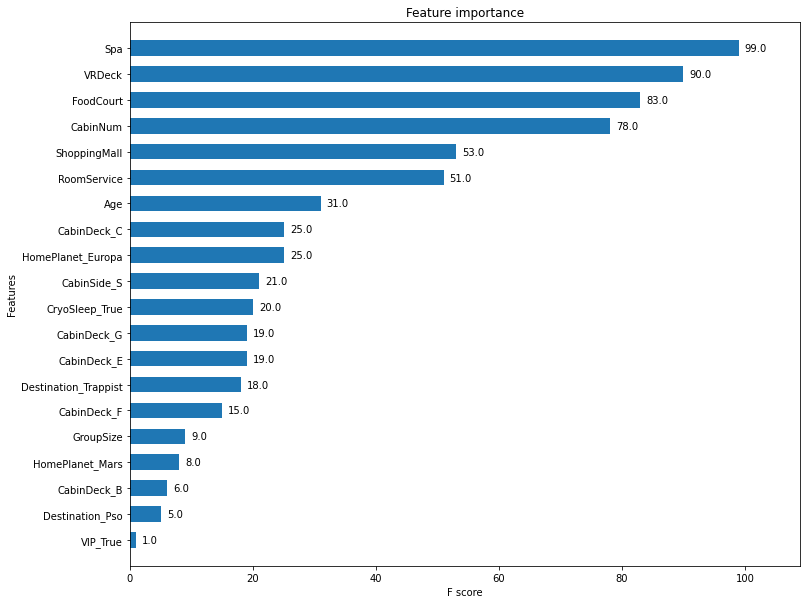

In [26]:
fig, ax = plt.subplots(figsize=(12,10))
plot_importance(xgbc_model, height=0.6, grid=False, ax=ax);

# Explore NaNs and fill missing data

In [27]:
# Reload full train data
full_train_df = pd.read_csv('./data/train.csv')
full_train_df.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [28]:
# Comput group size of each passenger (before droping any samples)
full_train_df[['PassengerId_g', 'PassengerId_p']] = full_train_df['PassengerId'].str.split(pat='_', n=1, expand=True)
full_train_df['PassengerId_p'] = full_train_df['PassengerId_p'].astype(float)
full_train_df['GroupSize'] = full_train_df.apply(lambda row: full_train_df[full_train_df['PassengerId_g'] == row.PassengerId_g].PassengerId_p.max(), axis=1)
full_train_df = full_train_df.drop(['PassengerId_g', 'PassengerId_p'], axis=1)
full_train_df = full_train_df.set_index('PassengerId', drop=True)

In [29]:
# as long as Name is unused
full_train_df['Name'] = full_train_df['Name'].fillna('John Doe')
full_train_df[['NameFirst', 'NameLast']] = full_train_df['Name'].str.split(pat=' ', n=2, expand=True)
full_train_df = full_train_df.drop(['Name'], axis=1)

In [30]:
# Drop samples with more than 1 "NaN" - it's too corupte and has not effect on learning process.
full_train_df = full_train_df[full_train_df.isna().sum(axis=1) < 2]

In [31]:
full_train_df = full_train_df.replace({'TRAPPIST-1e': 'Trappist', '55 Cancri e': 'Cancri', 'PSO J318.5-22': 'Pso'})

In [32]:
cols = ['VIP', 'HomePlanet', 'Destination', 'CryoSleep']
df = pd.DataFrame()
for col in cols:
    curr_sr = full_train_df[col]
    curr_sr = pd.get_dummies(curr_sr.dropna(), prefix=col, drop_first=True).reindex(curr_sr.index)
    df = pd.concat([df, curr_sr], axis=1)
full_train_df = pd.concat([full_train_df, df], axis=1).drop(cols, axis=1)

In [33]:
col = 'Cabin'
sr = full_train_df[col]
clean_sr = sr.dropna()
clean_df = pd.DataFrame()
clean_df[['CabinDeck', 'CabinNum', 'CabinSide']] = clean_sr.str.split(pat='/', n=2, expand=True)
df = pd.get_dummies(clean_df.drop('CabinNum', axis=1), drop_first=True)
df['CabinNum'] = clean_df['CabinNum'].astype(float)
df = df.reindex(full_train_df.index)
full_train_df = pd.concat([full_train_df, df], axis=1).drop(col, axis=1)

In [34]:
full_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8510 entries, 0001_01 to 9280_02
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Age                   8357 non-null   float64
 1   RoomService           8360 non-null   float64
 2   FoodCourt             8363 non-null   float64
 3   ShoppingMall          8344 non-null   float64
 4   Spa                   8352 non-null   float64
 5   VRDeck                8356 non-null   float64
 6   Transported           8510 non-null   bool   
 7   GroupSize             8510 non-null   float64
 8   NameFirst             8510 non-null   object 
 9   NameLast              8510 non-null   object 
 10  VIP_True              8344 non-null   float64
 11  HomePlanet_Europa     8342 non-null   float64
 12  HomePlanet_Mars       8342 non-null   float64
 13  Destination_Pso       8361 non-null   float64
 14  Destination_Trappist  8361 non-null   float64
 15  CryoSleep_True   

In [35]:
%%time
import warnings
warnings.filterwarnings('ignore')

cols_for_classification = ['HomePlanet_Europa', 'HomePlanet_Mars', 'CabinDeck_B',
       'CabinDeck_C', 'CabinDeck_D', 'CabinDeck_E', 'CabinDeck_F',
       'CabinDeck_G', 'CabinDeck_T', 'CabinSide_S', 'VIP_True',
       'CryoSleep_True', 'Destination_Pso', 'Destination_Trappist']

for col_to_predict in cols_for_classification:
    train_x = train_df.drop([col_to_predict, 'NameFirst', 'NameLast'], axis=1)
    train_y = train_df[col_to_predict]

    train_mean = train_x.mean()
    train_std = train_x.std()
    train_x = (train_x - train_mean)/train_std

    xgbc_model = XGBClassifier()

    xgbc_params = {
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100],
    'max_depth': [3, 5, 7],
    'gamma': [0, 1],
    'subsample': [0.7, 1],
    'colsample_bytree': [0.7, 1]
    }

    n_folds = 50

    grid =GridSearchCV(xgbc_model, xgbc_params, cv=n_folds, n_jobs=-1, scoring='accuracy');
    grid.fit(train_x,train_y);

    xgbc_model = XGBClassifier(**grid.best_params_)
    xgbc_model.fit(train_x,train_y);

    missing_df = full_train_df[full_train_df[col_to_predict].isna()]
    data = missing_df.drop([col_to_predict, 'NameFirst', 'NameLast'], axis=1)
    data = (data - train_mean)/train_std
    prediction = xgbc_model.predict(data)
    missing_df[col_to_predict] = prediction
    full_train_df[col_to_predict] = full_train_df[col_to_predict].fillna(missing_df[col_to_predict])

CPU times: total: 5min 54s
Wall time: 30min 29s


In [36]:
from xgboost import XGBRegressor

In [37]:
%%time
import warnings
warnings.filterwarnings('ignore')

cols_for_regression = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'CabinNum']

for col_to_predict in cols_for_regression:
    train_x = train_df.drop([col_to_predict, 'NameFirst', 'NameLast'], axis=1)
    train_y = train_df[col_to_predict]

    train_mean = train_x.mean()
    train_std = train_x.std()
    train_x = (train_x - train_mean)/train_std

    xgbc_model = XGBRegressor()

    xgbc_params = {
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100],
    'max_depth': [3, 5, 7],
    'gamma': [0, 1],
    'subsample': [0.7, 1],
    'colsample_bytree': [0.7, 1]
    }

    n_folds = 50

    grid =GridSearchCV(xgbc_model, xgbc_params, cv=n_folds, n_jobs=-1, scoring='accuracy');
    grid.fit(train_x,train_y);

    xgbr_model = XGBRegressor(**grid.best_params_)
    xgbr_model.fit(train_x,train_y);

    missing_df = full_train_df[full_train_df[col_to_predict].isna()]
    data = missing_df.drop([col_to_predict, 'NameFirst', 'NameLast'], axis=1)
    data = (data - train_mean)/train_std
    prediction = xgbr_model.predict(data)
    missing_df[col_to_predict] = prediction
    full_train_df[col_to_predict] = full_train_df[col_to_predict].fillna(missing_df[col_to_predict])

CPU times: total: 3min 4s
Wall time: 18min 8s


In [38]:
full_train_df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,GroupSize,VIP_True,HomePlanet_Europa,HomePlanet_Mars,...,CryoSleep_True,CabinDeck_B,CabinDeck_C,CabinDeck_D,CabinDeck_E,CabinDeck_F,CabinDeck_G,CabinDeck_T,CabinSide_S,CabinNum
count,8510.000000,8510.000000,8510.000000,8510.000000,8510.000000,8510.000000,8510.000000,8510.000000,8510.000000,8510.000000,...,8510.000000,8510.000000,8510.000000,8510.000000,8510.000000,8510.000000,8510.000000,8510.000000,8510.000000,8510.000000
mean,28.669380,223.880116,455.082885,173.963908,310.009250,300.779457,2.035605,0.023032,0.251821,0.207168,...,0.349236,0.090364,0.085781,0.060870,0.110576,0.333255,0.301410,0.000470,0.499060,597.664214
std,14.402751,658.708887,1603.119360,597.675973,1132.906639,1135.128814,1.597617,0.150013,0.434085,0.405301,...,0.476757,0.286720,0.280057,0.239105,0.313625,0.471405,0.458897,0.021676,0.500028,508.064395
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,172.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,425.500000
75%,37.000000,68.750000,104.000000,40.000000,79.750000,61.000000,3.000000,0.000000,1.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,989.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000,8.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1894.000000


CPU times: total: 3min 17s
Wall time: 3min 17s


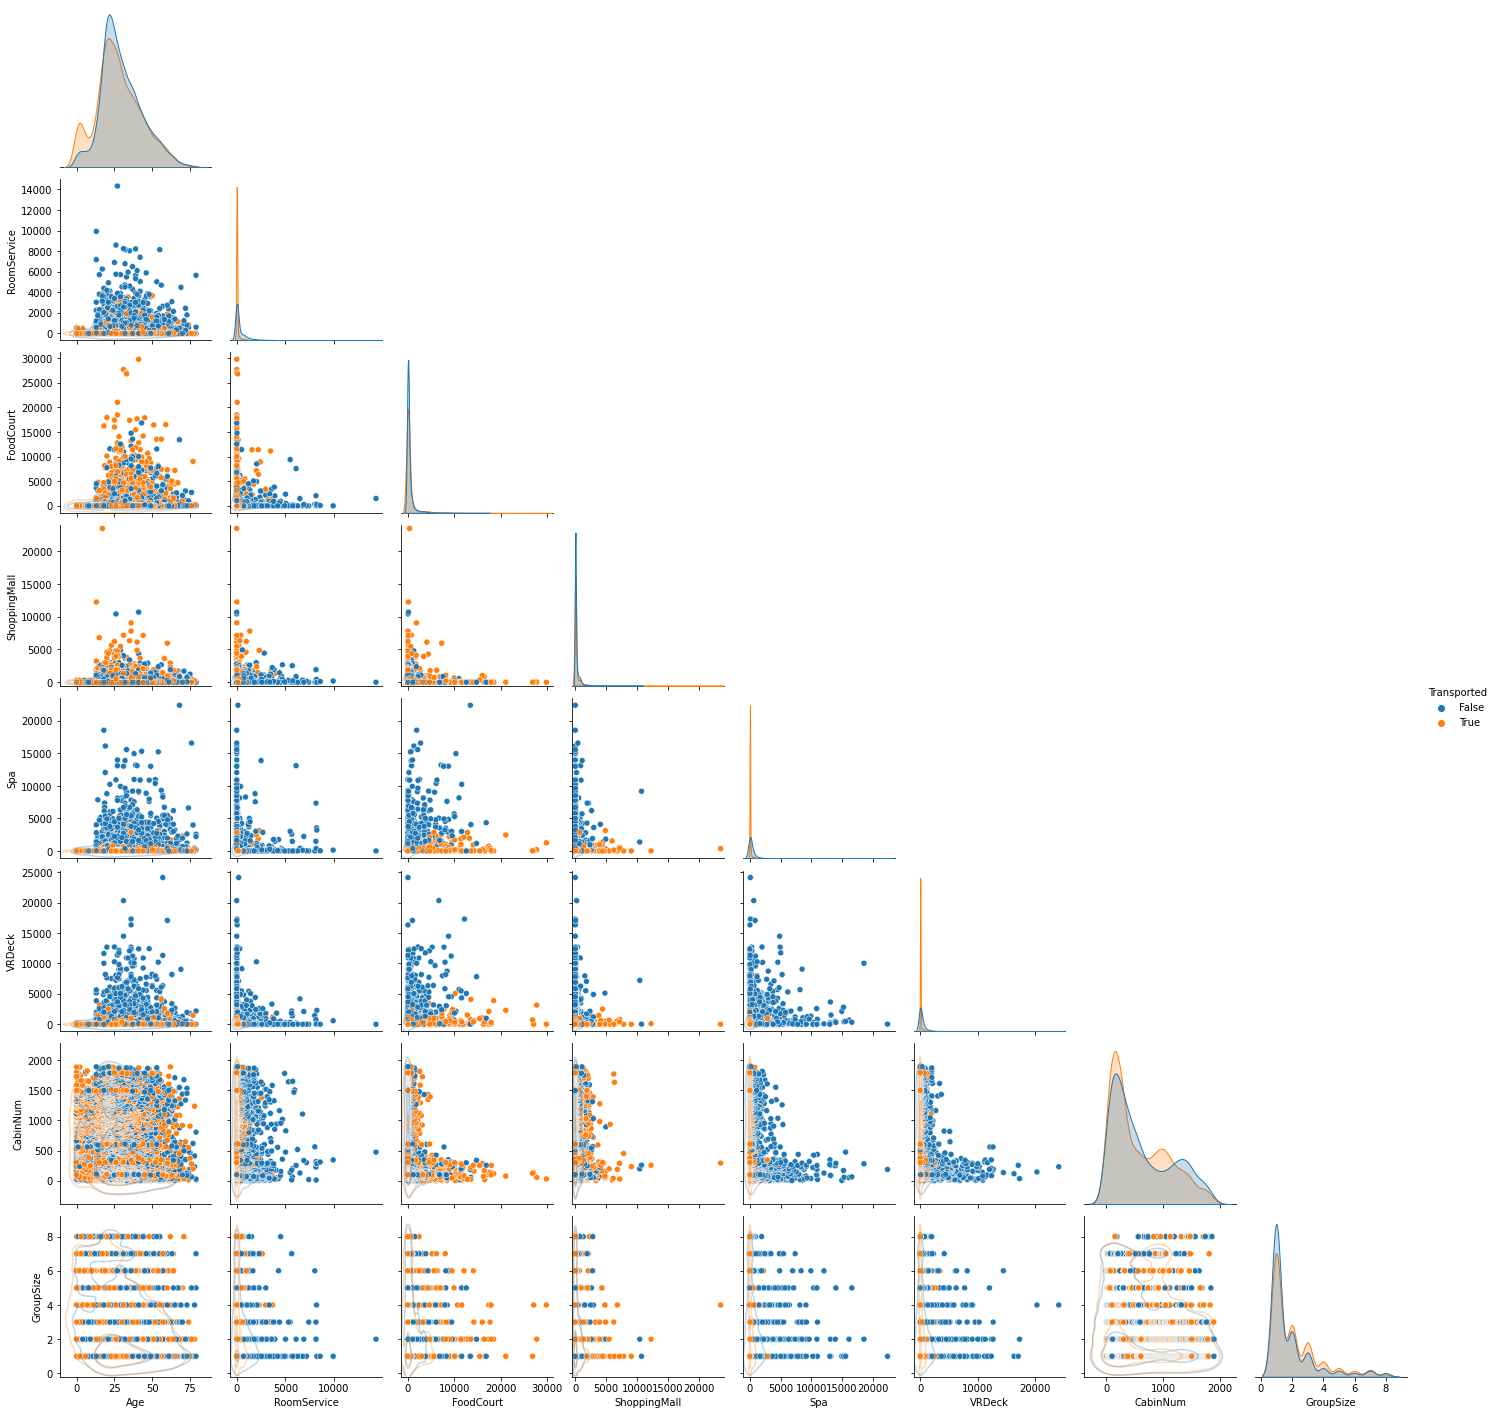

In [39]:
%%time
numerical_columns = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'CabinNum', 'GroupSize']
pairplot_graph = sns.pairplot(full_train_df[numerical_columns + ['Transported']], corner=True, hue='Transported', diag_kind="kde");
pairplot_graph.map_lower(sns.kdeplot, levels=3, color=".2", alpha=0.3);

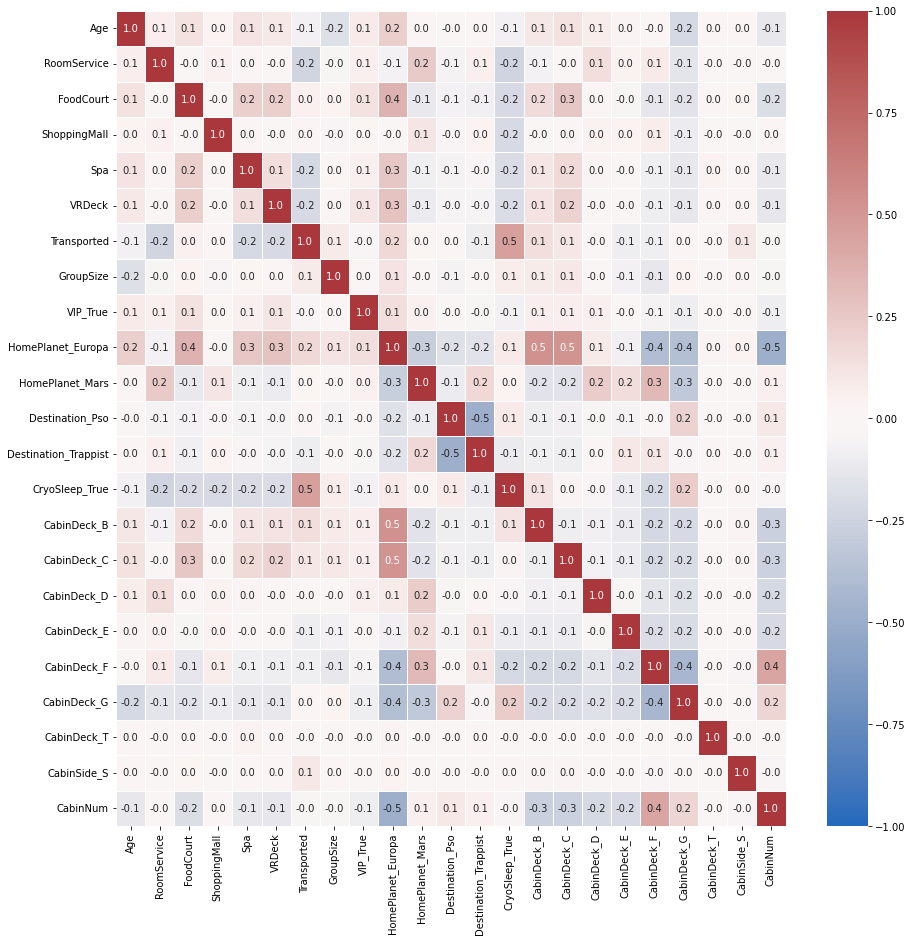

In [40]:
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(full_train_df.corr(), cmap='vlag', vmin=-1, vmax=1, annot=True, linewidths=.5, fmt='.1f', ax=ax);

# Classification (full data)

In [41]:
train_x = full_train_df.drop(columns=['Transported', 'NameFirst', 'NameLast'])
train_y = full_train_df.Transported

In [42]:
train_x = (train_x - train_x.mean())/train_x.std()

In [43]:
xgbc_model = XGBClassifier()

In [44]:
xgbc_params = {
'learning_rate': [0.1],   # [0.01, 0.1],
'n_estimators': [100],    # [100],
'max_depth': [3],         # [3, 5, 7],
'gamma': [1],             # [0, 1],
'subsample': [1],         # [0.7, 1],
'colsample_bytree': [1] # [0.7, 1]
}

n_folds = 1000

grid =GridSearchCV(xgbc_model, xgbc_params, cv=n_folds, n_jobs=-1, scoring='accuracy');

In [45]:
%%time
grid.fit(train_x,train_y);
grid.best_params_

CPU times: total: 7.73 s
Wall time: 53.1 s


{'colsample_bytree': 1,
 'gamma': 1,
 'learning_rate': 0.1,
 'max_depth': 3,
 'n_estimators': 100,
 'subsample': 1}

In [46]:
grid.best_score_

0.8097083333333335

In [47]:
# current best score:
# grid.best_score_ = 0.8097083333333335

# grid.best_params_ = 
# {'colsample_bytree': 1,
#  'gamma': 1,
#  'learning_rate': 0.1,
#  'max_depth': 3,
#  'n_estimators': 100,
#  'subsample': 1}

## Feature importance (full data)

In [48]:
xgbc_model = XGBClassifier(**grid.best_params_)
xgbc_model.fit(train_x,train_y);

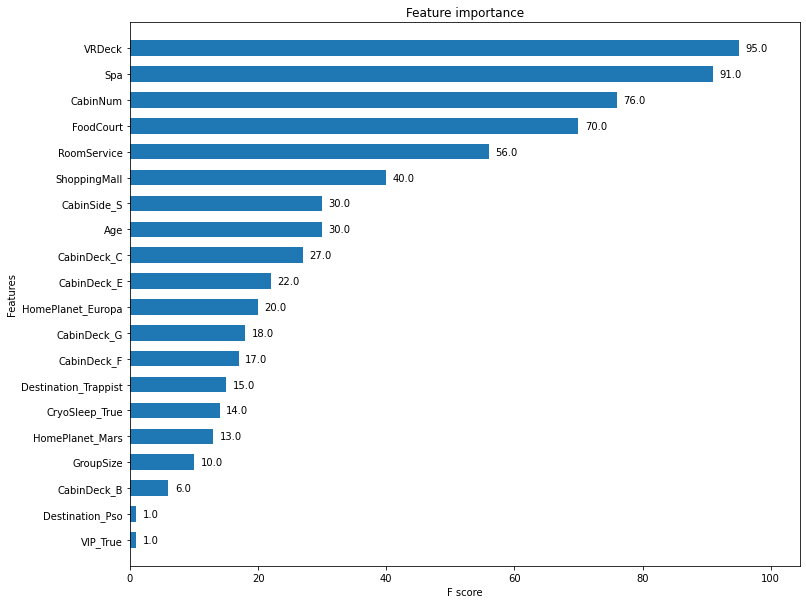

In [49]:
fig, ax = plt.subplots(figsize=(12,10))
plot_importance(xgbc_model, height=0.6, grid=False, ax=ax);

# Explore test data

In [50]:
test_df = pd.read_csv('./data/test.csv')
test_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [51]:
test_df.shape

(4277, 13)

In [52]:
test_df.isna().sum()

PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64

In [53]:
test_df[test_df.isna().sum(axis=1) > 1].isna().sum() # 2 or more nans in same row

PassengerId      0
HomePlanet      23
CryoSleep       20
Cabin           18
Destination     24
Age             23
VIP             22
RoomService     11
FoodCourt       14
ShoppingMall    23
Spa             20
VRDeck          20
Name            20
dtype: int64